# Debugging Performance Issues

Most chapters of this book deal with _functional_ issues – that is, issues related to the _functionality_ (or its absence) of the code in question. However, debugging can also involve _nonfunctional_ issues, however – performance, usability, reliability, and more. In this chapter, we give a short introduction on how to debug such nonfunctional issues, notably _performance_ issues.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("0tMeB9G0uUI")

**Prerequisites**

* This chapter leverages visualization capabilities from [the chapter on statistical debugging](StatisticalDebugger.ipynb).
* We also show how to debug nonfunctional issues using [delta debugging](DeltaDebugger.ipynb).

In [2]:
import bookutils

In [3]:
import StatisticalDebugger
import DeltaDebugger

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.PerformanceDebugger import <identifier>
```

and then make use of the following features.


This chapter provides a class `PerformanceDebugger` that allows to measure and visualize the time taken per line in a function.

```python
>>> with PerformanceDebugger(TimeCollector) as debugger:
>>>     for i in range(100):
>>>         s = remove_html_markup('<b>foo</b>')
```
The distribution of executed time within each function can be obtained by printing out the debugger:

```python
>>> print(debugger)
 238   2% def remove_html_markup(s):  # type: ignore
 239   2%     tag = False
 240   1%     quote = False
 241   1%     out = ""
 242   0%
 243  17%     for c in s:
 244  15%         assert tag or not quote
 245   0%
 246  14%         if c == '<' and not quote:
 247   3%             tag = True
 248  11%         elif c == '>' and not quote:
 249   3%             tag = False
 250   9%         elif (c == '"' or c == "'") and tag:
 251   0%             quote = not quote
 252   9%         elif not tag:
 253   4%             out = out + c
 254   0%
 255   2%     return out


```
The sum of all percentages in a function should always be 100%.

These percentages can also be visualized, where darker shades represent higher percentage values:

```python
>>> debugger
```
<pre style="background-color:hsl(240, 100%, 96.93939024391706%)"
                    title="Line 238:   2% 0.0002377084456384182"> 238 def remove_html_markup(s):  # type: ignore</pre>
<pre style="background-color:hsl(240, 100%, 97.10727336019127%)"
                    title="Line 239:   2% 0.0002246694639325142"> 239     tag = False</pre>
<pre style="background-color:hsl(240, 100%, 97.35684818140514%)"
                    title="Line 240:   1% 0.0002052857307717204"> 240     quote = False</pre>
<pre style="background-color:hsl(240, 100%, 97.51027288066227%)"
                    title="Line 241:   1% 0.00019336969126015902"> 241     out = &quot;&quot;</pre>
<pre style="background-color:hsl(240, 100%, 100.0%)"
                    title="Line 242:   0% 0.0"> 242 &nbsp;</pre>
<pre style="background-color:hsl(240, 100%, 75.0%)"
                    title="Line 243:  17% 0.001941675553098321"> 243     for c in s:</pre>
<pre style="background-color:hsl(240, 100%, 78.84232207393477%)"
                    title="Line 244:  15% 0.0016432538395747542"> 244         assert tag or not quote</pre>
<pre style="background-color:hsl(240, 100%, 100.0%)"
                    title="Line 245:   0% 0.0"> 245 &nbsp;</pre>
<pre style="background-color:hsl(240, 100%, 79.21628934485113%)"
                    title="Line 246:  14% 0.001614208915270865"> 246         if c == &#x27;&lt;&#x27; and not quote:</pre>
<pre style="background-color:hsl(240, 100%, 95.77364102571482%)"
                    title="Line 247:   3% 0.00032824871595948935"> 247             tag = True</pre>
<pre style="background-color:hsl(240, 100%, 83.23885898477751%)"
                    title="Line 248:  11% 0.0013017879100516438"> 248         elif c == &#x27;&gt;&#x27; and not quote:</pre>
<pre style="background-color:hsl(240, 100%, 95.77201321720554%)"
                    title="Line 249:   3% 0.0003283751429989934"> 249             tag = False</pre>
<pre style="background-color:hsl(240, 100%, 86.49741085515046%)"
                    title="Line 250:   9% 0.0010487058898434043"> 250         elif (c == &#x27;&quot;&#x27; or c == &quot;&#x27;&quot;) and tag:</pre>
<pre style="background-color:hsl(240, 100%, 100.0%)"
                    title="Line 251:   0% 0.0"> 251             quote = not quote</pre>
<pre style="background-color:hsl(240, 100%, 86.80520905917705%)"
                    title="Line 252:   9% 0.001024800119921565"> 252         elif not tag:</pre>
<pre style="background-color:hsl(240, 100%, 93.76882846831433%)"
                    title="Line 253:   4% 0.0004839565372094512"> 253             out = out + c</pre>
<pre style="background-color:hsl(240, 100%, 100.0%)"
                    title="Line 254:   0% 0.0"> 254 &nbsp;</pre>
<pre style="background-color:hsl(240, 100%, 95.79171929314619%)"
                    title="Line 255:   2% 0.0003268446307629347"> 255     return out</pre>


The abstract `MetricCollector` class allows subclassing to build more collectors, such as `HitCollector`.

![](PICS/PerformanceDebugger-synopsis-1.svg)



## Measuring Performance

The solution to debugging performance issues fits in two simple rules:

1. _Measure_ performance
2. _Break down_ how individual parts of your code contribute to performance.

The first part, actually _measuring_ performance, is key here. Developers often take elaborated guesses on which aspects of their code impact performance, and think about all possible ways to optimize their code – and at the same time, making it harder to understand, harder to evolve, and harder to maintain. In most cases, such guesses are wrong. Instead, _measure_ performance of your program, _identify_ the very few parts that may need to get improved, and again _measure_ the impact of your changes.

Almost all programming languages offer a way to measure performance and breaking it down to individual parts of the code – a means also known as *profiling*. Profiling works by measuring the execution time for each function (or even more fine-grained location) in your program. This can be achieved by

1. _Instrumenting_ or _tracing_ code such that the current time at entry and exit of each function (or line), thus determining the time spent. In Python, this is achieved by profilers like [profile or cProfile](https://docs.python.org/3/library/profile.html)

2. _Sampling_ the current function call stack at regular intervals, and thus assessing which functions are most active (= take the most time) during execution. For Python, the [scalene](https://github.com/plasma-umass/scalene) profiler works this way.

Pretty much all programming languages support profiling, either through measuring, sampling, or both. As a rule of thumb, _interpreted_ languages more frequently support measuring (as it is easy to implement in an interpreter), while _compiled_ languages more frequently support sampling (because instrumentation requires recompilation). Python is lucky to support both methods.

### Tracing Execution Profiles

Let us illustrate profiling in a simple example. The `ChangeCounter` class (which we will encounter in the [chapter on mining version histories](ChangeCounter.ipynb) reads in a version history from a git repository. Yet, it takes more than a minute to read in the debugging book change history:

In [4]:
from ChangeCounter import ChangeCounter, debuggingbook_change_counter  # minor dependency

In [5]:
import Timer

In [6]:
with Timer.Timer() as t:
    change_counter = debuggingbook_change_counter(ChangeCounter)

In [7]:
t.elapsed_time()

146.84254824998789

The Python `profile` and `cProfile` modules offer a simple way to identify the most time-consuming functions. They are invoked using the `run()` function, whose argument is the command to be profiled. The output reports, for each function encountered:

* How often it was called (`ncalls` column)
* How much time was spent in the given function, _excluding_ time spent in calls to sub-functions (`tottime` column)
* The fraction of `tottime` / `ncalls` (first `percall` column)
* How much time was spent in the given function, _including_ time spent in calls to sub-functions (`cumtime` column)
* The fraction of `cumtime` / `percall` (second `percall` column)

Let us have a look at the profile we obtain:

In [8]:
import cProfile

In [9]:
cProfile.run('debuggingbook_change_counter(ChangeCounter)', sort='cumulative')

         15844999 function calls (15734477 primitive calls) in 149.534 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  149.534  149.534 {built-in method builtins.exec}
        1    0.000    0.000  149.534  149.534 <string>:1(<module>)
        1    0.000    0.000  149.534  149.534 ChangeCounter.ipynb:165(debuggingbook_change_counter)
        1    0.000    0.000  149.534  149.534 ChangeCounter.ipynb:51(__init__)
        1    1.355    1.355  149.534  149.534 ChangeCounter.ipynb:88(mine)
      993    0.020    0.000  147.831    0.149 ChangeCounter.ipynb:99(mine_commit)
      993    0.050    0.000  147.661    0.149 commit.py:657(modified_files)
      993    0.037    0.000  147.610    0.149 commit.py:673(_get_modifications)
      958    0.200    0.000   76.571    0.080 diff.py:95(diff)
      993    0.071    0.000   70.960    0.071 commit.py:707(_parse_diff)
    18618    0.189    0.000   70.150    0.0

Yes, that's an awful lot of functions, but we can quickly narrow things down. The `cumtime` column is sorted by largest values first. We see that the `debuggingbook_change_counter()` method at the top takes up all the time – but this is not surprising, since it it the method we called in the first place. This calls a method `mine()` in the `ChangeCounter` class, which does all the work.

The next places are more interesting: almost all time is spent in a single method, named `modifications()`. This method determines the difference between two versions, which is an expensive operation; this is also supported by the observation that half of the time is spent in a `diff()` method.

This profile thus already gets us a hint on how to improve performance: Rather than computing the diff between versions for _every_ version, we could do so _on demand_ (and possibly cache results so we don't have to compute them twice). Alas, this (slow) functionality is part of the 
underlying [PyDriller](https://pydriller.readthedocs.io/) Python package, so we cannot fix this within the `ChangeCounter` class. But we could file a bug with the developers, suggesting a patch to improve performance.

### Sampling Execution Profiles

Instrumenting code is _precise_, but it is also _slow_. An alternate way to measure performance is to _sample_ in regular intervals which functions are currently active – for instance, by examining the current function call stack. The more frequently a function is sampled as active, the more time is spent in that function.

One profiler for Python that implements such sampling is [Scalene](https://github.com/plasma-umass/scalene) – a high-performance, high-precision CPU, GPU, and memory profiler for Python. We can invoke it on our example as follows:

```sh
$ scalene --html test.py > scalene-out.html
```

where `test.py` is a script that again invokes

```python
debuggingbook_change_counter(ChangeCounter)
```

The output of `scalene` is sent to a HTML file (here, `scalene-out.html`) which is organized by _lines_ – that is, for each line, we see how much it contributed to overall execution time. Opening the output `scalene-out.html` in a HTML browswer, we see these lines:

![](PICS/scalene-out.png)

As with `cProfile`, above, we identify the `mine()` method in the `ChangeCounter` class as the main performance hog – and in the `mine()` method, it is the iteration over all modifications that takes all the time. Adding the option `--profile-all` to `scalene` would extend the profile to all executed code, including the `pydriller` third-party library.

Besides relying on sampling rather that tracing (which is more efficient) and breaking down execution time by line, `scalene` also provides additional information on memory usage and more. If `cProfile` is not sufficient, then `scalene` will bring profiling to the next level.

## Improving Performance

Identifying a culprit is not always that easy. Notably, when the first set of obvious performance hogs is fixed, it becomes more and more difficult to squeeze out additional performance – and, as stated above, such optimization may be in conflict with readability and maintainability of your code. Here are some simple ways to improve performance:

* **Efficient algorithms**. For many tasks, the simplest algorithm is not always the best performing one. Consider alternatives that may be more efficient, and _measure_ whether they pay off.

* **Efficient data types**. Remember that certain operations, such as looking up whether an element is contained, may take different amounts of time depending on the data structure. In Python, a query like `x in xs` takes (mostly) constant time if `xs` is a set, but linear time if `xs` is a list; these differences become significant as the size of `xs` grows.

* **Efficient modules**. In Python, most frequently used modules (or at least parts of) are implemented in C, which is way more efficient than plain Python. Rely on existing modules whenever possible. Or implement your own, _after_ having measured that this may pay off.

These are all things you can already use during programming – and also set up your code such that exchanging, say, one data type by another will still be possible later. This is best achieved by hiding implementation details (such as the used data types) behind an abstract interface used by your clients.

But beyond these points, remember the famous words by [Donald J. Knuth](https://en.wikipedia.org/wiki/Donald_Knuth):

In [10]:
from bookutils import quiz

In [11]:
quiz('Donald J. Knuth said: "Premature optimization..."',
    [
        "... is the root of all evil",
        "... requires lots of experience",
        "... should be left to assembly programmers",
        "... is the reason why TeX is so fast",
    ], 'len("METAFONT") - len("TeX") - len("CWEB")')

This quote should always remind us that after a good design, you should always _first_ measure and _then_ optimize.

## Building a Profiler

Having discussed profilers from a _user_ perspective, let us now dive into how they are actually implemented. It turns out we can use most of our existing infrastructure to implement a simple tracing profiler with only a few lines of code.

The program we will apply our profiler on is – surprise! – our ongoing example, `remove_html_markup()`. Our aim is to understand how much time is spent _in each line of the code_ (such that we have a new feature on top of Python `cProfile`).

In [12]:
from Intro_Debugging import remove_html_markup

In [13]:
# ignore
from typing import Any, Optional, Type, Dict, Tuple, List

In [14]:
# ignore
from bookutils import print_content

In [15]:
# ignore
import inspect

In [16]:
print_content(inspect.getsource(remove_html_markup), '.py',
              start_line_number=238)

238  def remove_html_markup(s):  # type: ignore
239      tag = False
240      quote = False
241      out = ""
242  
243      for c in s:
244          assert tag or not quote
245  
246          if c == '<' and not quote:
247              tag = True
248          elif c == '>' and not quote:
249              tag = False
250          elif (c == '"' or c == "'") and tag:
251              quote = not quote
252          elif not tag:
253              out = out + c
254  
255      return out

We introduce a class `PerformanceTracer` that tracks, for each line in the code:

* how _often_ it was executed (`hits`), and
* _how much time_ was spent during its execution (`time`).

To this end, we make use of our `Timer` class, which measures time, and the `Tracer` class from [the chapter on tracing](Tracer.ipynb), which allows us to track every line of the program as it is being executed.

In [17]:
from Tracer import Tracer

In `PerfomanceTracker`, the attributes `hits` and `time` are mappings indexed by unique locations – that is, pairs of function name and line number.

In [18]:
Location = Tuple[str, int]

In [19]:
class PerformanceTracer(Tracer):
    """Trace time and #hits for individual program lines"""

    def __init__(self) -> None:
        """Constructor."""
        super().__init__()
        self.reset_timer()
        self.hits: Dict[Location, int] = {}
        self.time: Dict[Location, float] = {}

    def reset_timer(self) -> None:
        self.timer = Timer.Timer()

As common in this book, we want to use `PerformanceTracer` in a `with`-block around the function call(s) to be tracked:

```python
with PerformanceTracer() as perf_tracer:
    function(...)
```

When entering the `with` block (`__enter__()`), we reset all timers. Also, coming from the `__enter__()` method of the superclass `Tracer`, we enable tracing through the `traceit()` method.

In [20]:
from types import FrameType

In [21]:
class PerformanceTracer(PerformanceTracer):
    def __enter__(self) -> Any:
        """Enter a `with` block."""
        super().__enter__()
        self.reset_timer()
        return self

The `traceit()` method extracts the current location. It increases the corresponding `hits` value by 1, and adds the elapsed time to the corresponding `time`.

In [22]:
class PerformanceTracer(PerformanceTracer):
    def traceit(self, frame: FrameType, event: str, arg: Any) -> None:
        """Tracing function; called for every line."""
        t = self.timer.elapsed_time()
        location = (frame.f_code.co_name, frame.f_lineno)

        self.hits.setdefault(location, 0)
        self.time.setdefault(location, 0.0)
        self.hits[location] += 1
        self.time[location] += t

        self.reset_timer()

This is it already. We can now determine where most time is spent in `remove_html_markup()`. We invoke it 10,000 times such that we can average over runs:

In [23]:
with PerformanceTracer() as perf_tracer:
    for i in range(10000):
        s = remove_html_markup('<b>foo</b>')

Here are the hits. For every line executed, we see how often it was executed. The most executed line is the `for` loop with 110,000 hits – once for each of the 10 characters in `<b>foo</b>`, once for the final check, and all of this 10,000 times.

In [24]:
perf_tracer.hits

{('__init__', 17): 1,
 ('__init__', 19): 1,
 ('clock', 8): 1,
 ('clock', 12): 2,
 ('__init__', 20): 2,
 ('remove_html_markup', 238): 10000,
 ('remove_html_markup', 239): 10000,
 ('remove_html_markup', 240): 10000,
 ('remove_html_markup', 241): 10000,
 ('remove_html_markup', 243): 110000,
 ('remove_html_markup', 244): 100000,
 ('remove_html_markup', 246): 100000,
 ('remove_html_markup', 247): 20000,
 ('remove_html_markup', 248): 80000,
 ('remove_html_markup', 250): 60000,
 ('remove_html_markup', 252): 60000,
 ('remove_html_markup', 249): 20000,
 ('remove_html_markup', 253): 30000,
 ('remove_html_markup', 255): 20000}

The `time` attribute collects how much time was spent in each line. Within the loop, again, the `for` statement takes the most time. The other lines show some variability, though.

In [25]:
perf_tracer.time

{('__init__', 17): 1.4791963621973991e-05,
 ('__init__', 19): 1.4170072972774506e-06,
 ('clock', 8): 9.59029421210289e-07,
 ('clock', 12): 1.7079291865229607e-06,
 ('__init__', 20): 1.8749851733446121e-06,
 ('remove_html_markup', 238): 0.01181604154407978,
 ('remove_html_markup', 239): 0.01100448495708406,
 ('remove_html_markup', 240): 0.010477809933945537,
 ('remove_html_markup', 241): 0.009863208630122244,
 ('remove_html_markup', 243): 0.09607127401977777,
 ('remove_html_markup', 244): 0.08492189913522452,
 ('remove_html_markup', 246): 0.08403587969951332,
 ('remove_html_markup', 247): 0.017245230148546398,
 ('remove_html_markup', 248): 0.06746642768848687,
 ('remove_html_markup', 250): 0.05015022412408143,
 ('remove_html_markup', 252): 0.053197916015051305,
 ('remove_html_markup', 249): 0.016956783249042928,
 ('remove_html_markup', 253): 0.02508688368834555,
 ('remove_html_markup', 255): 0.016856709611602128}

For a full profiler, these numbers would now be sorted and printed in a table, much like `cProfile` does. However, we will borrow some material from previous chapters and annotate our code accordingly.

## Visualizing Performance Metrics

In the [chapter on statistical debugging](StatisticalDebugger.ipynb), we have encountered the `CoverageCollector` class, which collects line and function coverage during execution, using a `collect()` method that is invoked for every line. We will repurpose this class to collect arbitrary _metrics_ on the lines executed, notably time taken.

### Collecting Time Spent

In [26]:
from StatisticalDebugger import CoverageCollector, SpectrumDebugger

The `MetricCollector` class is an abstract superclass that provides an interface to access a particular metric.

In [27]:
class MetricCollector(CoverageCollector):
    """Abstract superclass for collecting line-specific metrics"""

    def metric(self, event: Any) -> Optional[float]:
        """Return a metric for an event, or none."""
        return None

    def all_metrics(self, func: str) -> List[float]:
        """Return all metric for a function `func`."""
        return []

Given these metrics, we can also compute sums and maxima for a single function.

In [28]:
class MetricCollector(MetricCollector):
    def total(self, func: str) -> float:
        return sum(self.all_metrics(func))

    def maximum(self, func: str) -> float:
        return max(self.all_metrics(func))

Let us instantiate this superclass into `TimeCollector` – a subclass that measures time. This is modeled after our `PerformanceTracer` class, above; notably, the `time` attribute serves the same role.

In [29]:
class TimeCollector(MetricCollector):
    """Collect time executed for each line"""

    def __init__(self) -> None:
        """Constructor"""
        super().__init__()
        self.reset_timer()
        self.time: Dict[Location, float] = {}
        self.add_items_to_ignore([Timer.Timer, Timer.clock])

    def collect(self, frame: FrameType, event: str, arg: Any) -> None:
        """Invoked for every line executed. Accumulate time spent."""
        t = self.timer.elapsed_time()
        super().collect(frame, event, arg)
        location = (frame.f_code.co_name, frame.f_lineno)

        self.time.setdefault(location, 0.0)
        self.time[location] += t

        self.reset_timer()

    def reset_timer(self) -> None:
        self.timer = Timer.Timer()

    def __enter__(self) -> Any:
        super().__enter__()
        self.reset_timer()
        return self

The `metric()` and `all_metrics()` methods accumulate the metric (time taken) for an individual function:

In [30]:
class TimeCollector(TimeCollector):
    def metric(self, location: Any) -> Optional[float]:
        if location in self.time:
            return self.time[location]
        else:
            return None

    def all_metrics(self, func: str) -> List[float]:
        return [time
                for (func_name, lineno), time in self.time.items()
                if func_name == func]

Here's how to use `TimeCollector()` – again, in a `with` block:

In [31]:
with TimeCollector() as collector:
    for i in range(100):
        s = remove_html_markup('<b>foo</b>')

The `time` attribute holds the time spent in each line:

In [32]:
for location, time_spent in collector.time.items():
    print(location, time_spent)

('remove_html_markup', 238) 0.0002132478402927518
('remove_html_markup', 239) 0.0002000844106078148
('remove_html_markup', 240) 0.000177583540789783
('remove_html_markup', 241) 0.00017029442824423313
('remove_html_markup', 243) 0.001619775197468698
('remove_html_markup', 244) 0.0016120093641802669
('remove_html_markup', 246) 0.0014338846085593104
('remove_html_markup', 247) 0.00029063003603369
('remove_html_markup', 248) 0.0011636101407930255
('remove_html_markup', 250) 0.0008585775503888726
('remove_html_markup', 252) 0.0008953185752034187
('remove_html_markup', 249) 0.00028987741097807884
('remove_html_markup', 253) 0.00043625140096992254
('remove_html_markup', 255) 0.00029470829758793116


And we can also create a total for an entire function:

In [33]:
collector.total('remove_html_markup')

0.009655852802097797

### Visualizing Time Spent

Let us now go and visualize these numbers in a simple form. The idea is to assign each line a _color_ whose saturation indicates the time spent in that line relative to the time spent in the function overall  – the higher the fraction, the darker the line. We create a `MetricDebugger` class built as a specialization of `SpectrumDebugger`, in which `suspiciousness()` and `color()` are repurposed to show these metrics.

In [34]:
class MetricDebugger(SpectrumDebugger):
    """Visualize a metric"""

    def metric(self, location: Location) -> float:
        sum = 0.0
        for outcome in self.collectors:
            for collector in self.collectors[outcome]:
                assert isinstance(collector, MetricCollector)
                m = collector.metric(location)
                if m is not None:
                    sum += m  # type: ignore

        return sum

    def total(self, func_name: str) -> float:
        total = 0.0
        for outcome in self.collectors:
            for collector in self.collectors[outcome]:
                assert isinstance(collector, MetricCollector)
                total += sum(collector.all_metrics(func_name))

        return total

    def maximum(self, func_name: str) -> float:
        maximum = 0.0
        for outcome in self.collectors:
            for collector in self.collectors[outcome]:
                assert isinstance(collector, MetricCollector)
                maximum = max(maximum, 
                              max(collector.all_metrics(func_name)))

        return maximum

    def suspiciousness(self, location: Location) -> float:
        func_name, _ = location
        return self.metric(location) / self.total(func_name)

    def color(self, location: Location) -> str:
        func_name, _ = location
        hue = 240  # blue
        saturation = 100  # fully saturated
        darkness = self.metric(location) / self.maximum(func_name)
        lightness = 100 - darkness * 25
        return f"hsl({hue}, {saturation}%, {lightness}%)"

    def tooltip(self, location: Location) -> str:
        return f"{super().tooltip(location)} {self.metric(location)}"

We can now introduce `PerformanceDebugger` as a subclass of `MetricDebugger`, using an arbitrary `MetricCollector` (such as `TimeCollector`) to obtain the metric we want to visualize.

In [35]:
class PerformanceDebugger(MetricDebugger):
    """Collect and visualize a metric"""

    def __init__(self, collector_class: Type, log: bool = False):
        assert issubclass(collector_class, MetricCollector)
        super().__init__(collector_class, log=log)

With `PerformanceDebugger`, we inherit all the capabilities of `SpectrumDebugger`, such as showing the (relative) percentage of time spent in a table. We see that the `for` condition and the following `assert` take most of the time, followed by the first condition.

In [36]:
with PerformanceDebugger(TimeCollector) as debugger:
    for i in range(100):
        s = remove_html_markup('<b>foo</b>')

In [37]:
print(debugger)

 238   2% def remove_html_markup(s):  # type: ignore
 239   1%     tag = False
 240   1%     quote = False
 241   1%     out = ""
 242   0%
 243  22%     for c in s:
 244  15%         assert tag or not quote
 245   0%
 246  14%         if c == '<' and not quote:
 247   2%             tag = True
 248  11%         elif c == '>' and not quote:
 249   2%             tag = False
 250   8%         elif (c == '"' or c == "'") and tag:
 251   0%             quote = not quote
 252   8%         elif not tag:
 253   4%             out = out + c
 254   0%
 255   2%     return out



However, we can also visualize these percentages, using shades of blue to indicate those lines most time spent in:

In [38]:
debugger

238   2% def remove_html_markup(s):  # type: ignore
 239   1%     tag = False
 240   1%     quote = False
 241   1%     out = ""
 242   0%
 243  22%     for c in s:
 244  15%         assert tag or not quote
 245   0%
 246  14%         if c == '<' and not quote:
 247   2%             tag = True
 248  11%         elif c == '>' and not quote:
 249   2%             tag = False
 250   8%         elif (c == '"' or c == "'") and tag:
 251   0%             quote = not quote
 252   8%         elif not tag:
 253   4%             out = out + c
 254   0%
 255   2%     return out

### Other Metrics

Our framework is flexible enough to collect (and visualize) arbitrary metrics. This `HitCollector` class, for instance, collects how often a line is being executed.

In [39]:
class HitCollector(MetricCollector):
    """Collect how often a line is executed"""

    def __init__(self) -> None:
        super().__init__()
        self.hits: Dict[Location, int] = {}

    def collect(self, frame: FrameType, event: str, arg: Any) -> None:
        super().collect(frame, event, arg)
        location = (frame.f_code.co_name, frame.f_lineno)

        self.hits.setdefault(location, 0)
        self.hits[location] += 1

    def metric(self, location: Location) -> Optional[int]:
        if location in self.hits:
            return self.hits[location]
        else:
            return None

    def all_metrics(self, func: str) -> List[float]:
        return [hits
                for (func_name, lineno), hits in self.hits.items()
                if func_name == func]

We can plug in this class into `PerformanceDebugger` to obtain a distribution of lines executed:

In [40]:
with PerformanceDebugger(HitCollector) as debugger:
    for i in range(100):
        s = remove_html_markup('<b>foo</b>')

In total, during this call to `remove_html_markup()`, there are 6,400 lines executed:

In [41]:
debugger.total('remove_html_markup')

6400.0

Again, we can visualize the distribution as a table and using colors. We can see how the shade gets lighter in the lower part of the loop as individual conditions have been met.

In [42]:
print(debugger)

 238   1% def remove_html_markup(s):  # type: ignore
 239   1%     tag = False
 240   1%     quote = False
 241   1%     out = ""
 242   0%
 243  17%     for c in s:
 244  15%         assert tag or not quote
 245   0%
 246  15%         if c == '<' and not quote:
 247   3%             tag = True
 248  12%         elif c == '>' and not quote:
 249   3%             tag = False
 250   9%         elif (c == '"' or c == "'") and tag:
 251   0%             quote = not quote
 252   9%         elif not tag:
 253   4%             out = out + c
 254   0%
 255   3%     return out



In [43]:
debugger

238   1% def remove_html_markup(s):  # type: ignore
 239   1%     tag = False
 240   1%     quote = False
 241   1%     out = ""
 242   0%
 243  17%     for c in s:
 244  15%         assert tag or not quote
 245   0%
 246  15%         if c == '<' and not quote:
 247   3%             tag = True
 248  12%         elif c == '>' and not quote:
 249   3%             tag = False
 250   9%         elif (c == '"' or c == "'") and tag:
 251   0%             quote = not quote
 252   9%         elif not tag:
 253   4%             out = out + c
 254   0%
 255   3%     return out

## Integrating with Delta Debugging

Besides identifying causes for performance issues in the code, one may also search for causes in the _input_, using [Delta Debugging](DeltaDebugger.ipynb). This can be useful if one does not immediately want to embark into investigating the code, but maybe first determine external influences that are related to performance issues.

Here is a variant of `remove_html_markup()` that introduces a (rather obvious) performance issue.

In [44]:
import time

In [45]:
def remove_html_markup_ampersand(s: str) -> str:
    tag = False
    quote = False
    out = ""

    for c in s:
        assert tag or not quote

        if c == '&':
            time.sleep(0.1)  # <-- the obvious performance issue

        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif (c == '"' or c == "'") and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

We can easily trigger this issue by measuring time taken:

In [46]:
with Timer.Timer() as t:
    remove_html_markup_ampersand('&&&')
t.elapsed_time()

0.31409224995877594

Let us set up a test that checks whether the performance issue is present.

In [47]:
def remove_html_test(s: str) -> None:
    with Timer.Timer() as t:
        remove_html_markup_ampersand(s)
    assert t.elapsed_time() < 0.1

We can now apply delta debugging to determine a minimum input that causes the failure:

In [48]:
s_fail = '<b>foo&amp;</b>'

In [49]:
with DeltaDebugger.DeltaDebugger() as dd:
    remove_html_test(s_fail)

In [50]:
dd.min_args()

{'s': '&'}

For performance issues, however, a minimal input is often not enough to highlight the failure cause. This is because short inputs tend to take less processing time than longer inputs, which increases the risks of a spurious diagnosis. A better alternative is to compute a _maximum_ input where the issue does not occur:

In [51]:
s_pass = dd.max_args()

In [52]:
s_pass

{'s': '<b>fooamp;</b>'}

We see that the culprit character (the `&`) is removed. This tells us the failure-inducing difference – or, more precisely, the cause for the performance issue.

## Synopsis

This chapter provides a class `PerformanceDebugger` that allows to measure and visualize the time taken per line in a function.

In [53]:
with PerformanceDebugger(TimeCollector) as debugger:
    for i in range(100):
        s = remove_html_markup('<b>foo</b>')

The distribution of executed time within each function can be obtained by printing out the debugger:

In [54]:
print(debugger)

 238   2% def remove_html_markup(s):  # type: ignore
 239   2%     tag = False
 240   1%     quote = False
 241   1%     out = ""
 242   0%
 243  17%     for c in s:
 244  15%         assert tag or not quote
 245   0%
 246  14%         if c == '<' and not quote:
 247   3%             tag = True
 248  11%         elif c == '>' and not quote:
 249   3%             tag = False
 250   9%         elif (c == '"' or c == "'") and tag:
 251   0%             quote = not quote
 252   9%         elif not tag:
 253   4%             out = out + c
 254   0%
 255   2%     return out



The sum of all percentages in a function should always be 100%.

These percentages can also be visualized, where darker shades represent higher percentage values:

In [55]:
debugger

238   2% def remove_html_markup(s):  # type: ignore
 239   2%     tag = False
 240   1%     quote = False
 241   1%     out = ""
 242   0%
 243  17%     for c in s:
 244  15%         assert tag or not quote
 245   0%
 246  14%         if c == '<' and not quote:
 247   3%             tag = True
 248  11%         elif c == '>' and not quote:
 249   3%             tag = False
 250   9%         elif (c == '"' or c == "'") and tag:
 251   0%             quote = not quote
 252   9%         elif not tag:
 253   4%             out = out + c
 254   0%
 255   2%     return out

The abstract `MetricCollector` class allows subclassing to build more collectors, such as `HitCollector`.

In [56]:
# ignore
from ClassDiagram import display_class_hierarchy

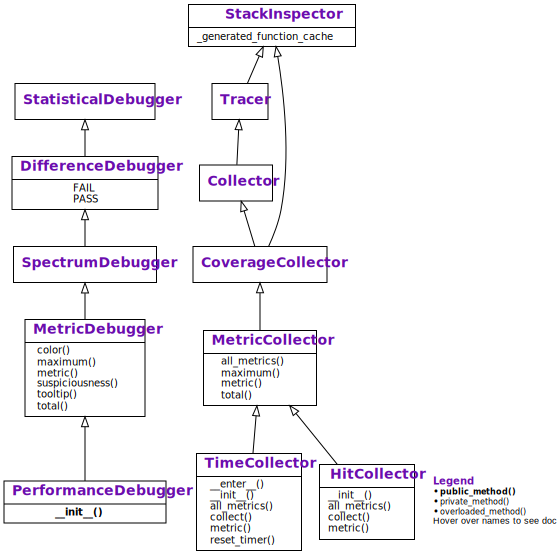

In [57]:
# ignore
display_class_hierarchy([PerformanceDebugger, TimeCollector, HitCollector],
                        public_methods=[
                            PerformanceDebugger.__init__,
                        ],
                        project='debuggingbook')

## Lessons Learned

* To measure performance,
    * instrument the code such that the time taken per function (or line) is collected; or
    * sample the execution that at regular intervals, the active call stack is collected.
* To make code performant, focus on efficient algorithms, efficient data types, and sufficient abstraction such that you can replace them by alternatives.
* Beyond efficient algorithms and data types, do _not_ optimize before measuring.

## Next Steps

This chapter concludes the part on abstracting failures. The next part will focus on

* [repairing code automatically](Repairer.ipynb)

## Background

[Scalene](https://github.com/plasma-umass/scalene) is a high-performance, high-precision CPU, GPU, and memory profiler for Python. In contrast to the standard Python `cProfile` profiler, it uses _sampling_ instead of instrumentation or relying on Python's tracing facilities; and it also supports line-by-line profiling. Scalene might be the tool of choice if you want to go beyond basic profiling.

The Wikipedia articles on [profiling](https://en.wikipedia.org/wiki/Profiling_(computer_programming)) and [performance analysis tools](https://en.wikipedia.org/wiki/List_of_performance_analysis_tools) provide several additional resources on profiling tools and how to apply them in practice.

## Exercises

### Exercise 1: Profiling Memory Usage

The Python [`tracemalloc` module](https://docs.python.org/3/library/tracemalloc.html) allows to track memory usage during execution. Between `tracemalloc.start()` and `tracemalloc.end()`, use `tracemalloc.get_traced_memory()` to obtain how much memory is currently being consumed:

In [58]:
import tracemalloc

In [59]:
tracemalloc.start()

In [60]:
current_size, peak_size = tracemalloc.get_traced_memory()
current_size

19704

In [61]:
tracemalloc.stop()

Create a subclass of `MetricCollector` named `MemoryCollector`. Have it measure the memory consumption before and after each line executed (0 if negative), and visualize the impact of individual lines on memory. Create an appropriate test program that (temporarily) consumes larger amounts of memory.

## Exercise 2: Statistical Performance Debugging

In a similar way as we integrated a binary "performance test" with delta debugging, we can also integrate such a test with other techniques. Combining a performance test with [Statistical Debugging](StatisticalDebugger.ipynb), for instance, will highlight those lines whose execution correlates with low performance. But then, the performance test need not be binary, as with functional pass/fail tests – you can also _weight_ individual lines by _how much_ they impact performance. Create a variant of `StatisticalDebugger` that reflects the impact of individual lines on an arbitrary (summarized) performance metric.